In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import argparse
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

In /Users/rogerxu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/rogerxu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/rogerxu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/rogerxu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/rogerxu/opt/anaconda3/lib/

In [2]:
#parser = argparse.ArgumentParser()
#parser.add_argument('-e', '--epochs', type=int, default=40, 
#           help='number of epochs to train the model for')
#args, unknown = parser.parse_args()
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)

In [3]:
image_dir = 'outputs/saved_images'
os.makedirs(image_dir, exist_ok=True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
batch_size = 2

cpu


In [4]:
gauss_blur = os.listdir('input/gaussian_blurred')
gauss_blur.sort()
sharp = os.listdir('input/sharp')
sharp.sort()
x_blur = []
for i in range(len(gauss_blur)):
    x_blur.append(gauss_blur[i])
y_sharp = []
for i in range(len(sharp)):
    y_sharp.append(sharp[i])

In [5]:
(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.25)
print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")

Train data instances: 262
Validation data instances: 88


In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transforms=None):
        self.X = blur_paths
        self.y = sharp_paths
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        blur_image = cv2.imread(f"input/gaussian_blurred/{self.X[i]}")
        
        if self.transforms:
            blur_image = self.transforms(blur_image)
            
        if self.y is not None:
            sharp_image = cv2.imread(f"input/sharp/{self.y[i]}")
            sharp_image = self.transforms(sharp_image)
            return (blur_image, sharp_image)
        else:
            return blur_image

In [8]:
train_data = DeblurDataset(x_train, y_train, transform)
val_data = DeblurDataset(x_val, y_val, transform)
 
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [9]:
class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x
model = DeblurCNN().to(device)
print(model)

DeblurCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [10]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=5,
        factor=0.5,
        verbose=True
    )

In [11]:
def fit(model, dataloader, epoch):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device)
        sharp_image = sharp_image.to(device)
        optimizer.zero_grad()
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss/len(dataloader.dataset)
    print(f"Train Loss: {train_loss:.5f}")
    
    return train_loss

In [12]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()
            if epoch == 0 and i == int((len(val_data)/dataloader.batch_size)-1):
                save_decoded_image(sharp_image.cpu().data, name=f"outputs/saved_images/sharp{epoch}.jpg")
                save_decoded_image(blur_image.cpu().data, name=f"outputs/saved_images/blur{epoch}.jpg")
            if i == int((len(val_data)/dataloader.batch_size)-1):
                save_decoded_image(outputs.cpu().data, name=f"outputs/saved_images/val_deblurred{epoch}.jpg")
        val_loss = running_loss/len(dataloader.dataset)
        print(f"Val Loss: {val_loss:.5f}")
        
        return val_loss

In [13]:
train_loss  = []
val_loss = []
start = time.time()

epochs = 40

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step(val_epoch_loss)
end = time.time()
print(f"Took {((end-start)/60):.3f} minutes to train")

Epoch 1 of 40


100%|█████████████████████████████████████████| 131/131 [01:37<00:00,  1.35it/s]


Train Loss: 0.01031


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.19it/s]


Val Loss: 0.00281
Epoch 2 of 40


100%|█████████████████████████████████████████| 131/131 [01:36<00:00,  1.36it/s]


Train Loss: 0.00223


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.19it/s]


Val Loss: 0.00178
Epoch 3 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00160


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.20it/s]


Val Loss: 0.00133
Epoch 4 of 40


100%|█████████████████████████████████████████| 131/131 [01:36<00:00,  1.36it/s]


Train Loss: 0.00126


100%|███████████████████████████████████████████| 44/44 [49:50<00:00, 67.97s/it]


Val Loss: 0.00110
Epoch 5 of 40


100%|█████████████████████████████████████████| 131/131 [43:33<00:00, 19.95s/it]


Train Loss: 0.00127


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.19it/s]


Val Loss: 0.00116
Epoch 6 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00096


100%|███████████████████████████████████████████| 44/44 [00:15<00:00,  2.86it/s]


Val Loss: 0.00091
Epoch 7 of 40


100%|█████████████████████████████████████████| 131/131 [01:38<00:00,  1.33it/s]


Train Loss: 0.00086


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.19it/s]


Val Loss: 0.00079
Epoch 8 of 40


100%|█████████████████████████████████████████| 131/131 [01:36<00:00,  1.36it/s]


Train Loss: 0.00108


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.20it/s]


Val Loss: 0.00096
Epoch 9 of 40


100%|█████████████████████████████████████████| 131/131 [01:37<00:00,  1.34it/s]


Train Loss: 0.00103


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.18it/s]


Val Loss: 0.00074
Epoch 10 of 40


100%|█████████████████████████████████████████| 131/131 [01:42<00:00,  1.28it/s]


Train Loss: 0.00072


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00068
Epoch 11 of 40


100%|█████████████████████████████████████████| 131/131 [01:38<00:00,  1.32it/s]


Train Loss: 0.00106


100%|███████████████████████████████████████████| 44/44 [00:14<00:00,  3.08it/s]


Val Loss: 0.00360
Epoch 12 of 40


100%|█████████████████████████████████████████| 131/131 [01:38<00:00,  1.32it/s]


Train Loss: 0.00201


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00072
Epoch 13 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00068


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00064
Epoch 14 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00063


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00060
Epoch 15 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00062


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00061
Epoch 16 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00060


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00065
Epoch 17 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00054


100%|███████████████████████████████████████████| 44/44 [00:14<00:00,  3.14it/s]


Val Loss: 0.00052
Epoch 18 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00066


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00069
Epoch 19 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00062


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00047
Epoch 20 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00050


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00058
Epoch 21 of 40


100%|█████████████████████████████████████████| 131/131 [01:40<00:00,  1.31it/s]


Train Loss: 0.00047


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00050
Epoch 22 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00043


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00047
Epoch 23 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00087


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00049
Epoch 24 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00084


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.17it/s]


Val Loss: 0.00059
Epoch 25 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00051


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00041
Epoch 26 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00043


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00040
Epoch 27 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00039


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00039
Epoch 28 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00047


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00042
Epoch 29 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00041


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00036
Epoch 30 of 40


100%|█████████████████████████████████████████| 131/131 [01:40<00:00,  1.31it/s]


Train Loss: 0.00035


100%|███████████████████████████████████████████| 44/44 [00:14<00:00,  3.13it/s]


Val Loss: 0.00034
Epoch 31 of 40


100%|█████████████████████████████████████████| 131/131 [01:40<00:00,  1.31it/s]


Train Loss: 0.00036


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00032
Epoch 32 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00039


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00032
Epoch 33 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00035


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00033
Epoch 34 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00046


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00078
Epoch 35 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00035


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.16it/s]


Val Loss: 0.00029
Epoch 36 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00032


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00029
Epoch 37 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00029


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00029
Epoch 38 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.32it/s]


Train Loss: 0.00066


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00090
Epoch 39 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00087


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]


Val Loss: 0.00036
Epoch 40 of 40


100%|█████████████████████████████████████████| 131/131 [01:39<00:00,  1.31it/s]


Train Loss: 0.00033


100%|███████████████████████████████████████████| 44/44 [00:13<00:00,  3.15it/s]

Val Loss: 0.00029
Took 167.039 minutes to train


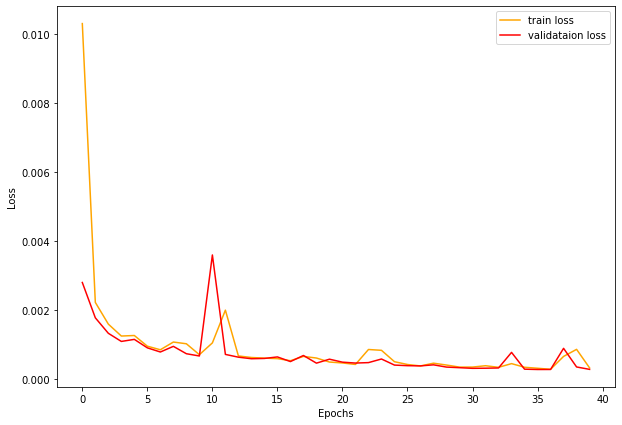

Saving model...


In [14]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/loss.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), 'outputs/model.pth')